<a href="https://colab.research.google.com/github/hwanin99/ComputerVision_Seminar/blob/main/%EA%B3%BC%EC%A0%9C/week4_%EA%B3%BC%EC%A0%9C%ED%92%80%EC%9D%B4%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [ ]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [ ]:
device

'cuda'

In [ ]:
root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
test_path = '/content/drive/MyDrive/CV_seminar_project/test'

# pytorch 데이터셋 클래스 실습

### 1. 파이토치 데이터 셋 클래스를 직접 만들어보자.

파이토치 데이터 셋 클래스는 init, getitem, len 특수 메소드 3개를 요구한다.   
 항상 같은 포맷을 만드는 습관이 중요하다. 
> 따라서 root_path, mode(train or validation or test), transform(전처리&Augmentation) 3개의 입력을 받아 data와 label을 출력하는 클래스를 만들도록하자.


In [ ]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob
from torch.utils.data import Dataset, DataLoader
import cv2
import os 

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms):
    self.all_data = sorted( glob.glob( os.path.join(root_path, mode, '*', '*') ) ) # 전체 경로
    self.transforms = transforms

  def __getitem__(self, index):
    if torch.is_tensor(index): # 인덱스가 tensor형태일 수 있는 것을 방지
      index = index.tolist()

    data_path = self.all_data[index] # 인덱스가 부여된 데이터 1개
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 라이브러리의 BGR 형식을 RGB로 permute

    # transfrom 적용
    if self.transforms is not None:
      augmentation = self.transforms(image = image)
      image = augmentation['image']

    # 이미지의 이름을 이용하여, label 부여하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

### 2. 전처리와 Augmentation을 적용한다.
> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> 텐서화: 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224), # 이미지 리사이즈
    A.Transpose(p=0.5), # 이미지 반전
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
# test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

# week4 과제
아래와 같이 원래 0~255 픽셀 값을 가진 귀여운 돌고래 이미지는 Augmentation이 적용되어(train_class[0][0]) 이미지가 변형 되었다.   
**train_class[0][0] 데이터**를 시각화 할 수 있도록 시각화 라이브러리가 요구하는 numpy 타입의 올바른 이미지 데이터로 되돌리는 역함수를 만들어 시각화 해오는 것.   

결과물에 대해서는 week4 pdf의 과제 설명에 있는 이미지를 보시면 이해될 것입니다.

In [ ]:
train_class.all_data

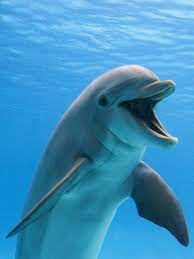

In [ ]:
from PIL import Image as PILImage
PILImage.open(train_class.all_data[0])

In [ ]:
import matplotlib.pyplot as plt
import cv2
cv2.imread(train_class.all_data[0])

array([[[205, 158,  76],
        [213, 166,  84],
        [221, 174,  92],
        ...,
        [235, 214, 162],
        [245, 222, 172],
        [247, 222, 172]],

       [[221, 173,  91],
        [228, 182,  98],
        [238, 190, 108],
        ...,
        [244, 222, 170],
        [241, 217, 165],
        [243, 216, 165]],

       [[228, 178,  95],
        [235, 188, 102],
        [246, 196, 113],
        ...,
        [255, 229, 175],
        [246, 218, 164],
        [246, 218, 164]],

       ...,

       [[231, 165,  46],
        [231, 165,  46],
        [230, 164,  45],
        ...,
        [232, 174,  69],
        [230, 172,  69],
        [228, 173,  69]],

       [[231, 164,  47],
        [231, 164,  47],
        [230, 164,  45],
        ...,
        [231, 174,  69],
        [230, 171,  71],
        [228, 172,  71]],

       [[231, 164,  47],
        [231, 164,  47],
        [230, 164,  45],
        ...,
        [231, 174,  69],
        [230, 171,  71],
        [228, 172,  71]]

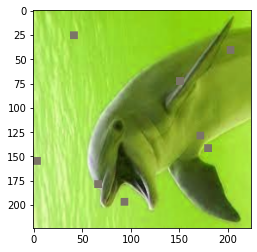

In [ ]:
image = train_class[0][0].permute(1, 2, 0).numpy()
# unnormalize
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

plt.imshow((((image * std)+mean)*255).astype(int))

In [ ]:
# Normalize -> (X - mean)/std, Unnomarize -> (X*std) + Mean -> 픽셀값 : 0 ~ 1 -> 0 ~ 255

In [ ]:
def converter(augmentationed_image):
  mean=(0.485, 0.456, 0.406)
  std=(0.229, 0.224, 0.225)
  
  ### 역함수 로직을 짜주세요. ###
  augmentationed_image = augmentationed_image.permute(1,2,0) # 채널축 정상적으로 맨뒤로 보내기
  augmentationed_image = augmentationed_image.numpy() # numpy 타입으로 변환
  augmentationed_image = (augmentationed_image * std) + mean # unnormalize
  converted_image = augmentationed_image * 255
  converted_image = converted_image.astype(int)

  return converted_image

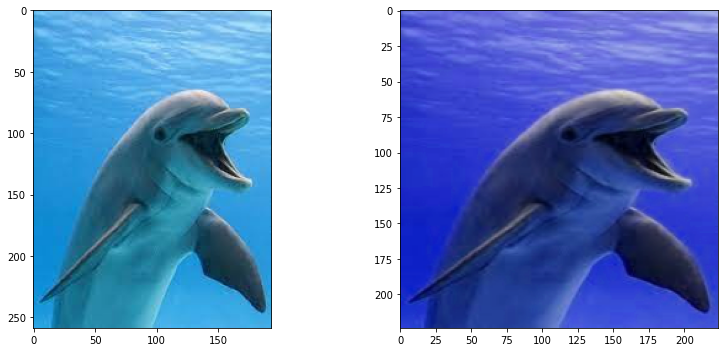

In [ ]:
import matplotlib.pyplot as plt
converted_image = converter(train_class[0][0])

plt.figure(figsize = (12,5))

plt.subplot(1, 2, 1) 
raw_image = plt.imread(train_class.all_data[0])
plt.imshow(raw_image)

plt.subplot(1, 2, 2) 
plt.imshow(converted_image)

plt.tight_layout()